In [1]:
import numpy as np 
import matplotlib.pyplot as plt
seq_dim=(6,6)

min_E = -np.prod(seq_dim)*2.
max_E = np.prod(seq_dim)*2.*3./4.
num_bins = int((max_E-min_E)/2)
bins = np.linspace(min_E-1./num_bins, max_E+1./num_bins, num_bins+2)

In [2]:
import os
import glob
def loadmodelprediction(_dirname, epoch=None, num_batches=1, file_header="logits"):
    dirname = _dirname
    f_logits_t = glob.glob(os.path.join(dirname, file_header+"_val_inttime*"))
    print(">>> Reading model predictions from: ", dirname)

    logits_t = np.array([np.load(f).astype(np.float16) for f in f_logits_t])
    diffusion_t = np.array([float(x.replace(os.path.join(dirname, file_header+"_val_inttime"), "").replace(".npy",""))-1 for x in f_logits_t])
    idx_order = np.argsort(diffusion_t)
    logits_t = logits_t[idx_order]
    diffusion_t = diffusion_t[idx_order]
    return logits_t, diffusion_t

def logits2seq(logits_t):
    seq_t = []
    for logits in logits_t:
        seq = np.argmax(logits, axis=-1)
        seq[np.where(seq==0)] = -1
        seq_t.append(seq.reshape(-1,*seq_dim))
    return seq_t

def Ising_magnetization(seq):
    data = np.sum(seq.reshape([-1,np.prod(seq_dim)]), axis=-1)
    return data

def pbc(i,L=seq_dim[0]):
    assert i>=-1 and i<=L
    if i-L == 0:
        return 0
    elif i == -1:
        return L-1
    else:
        return i
    
from copy import deepcopy
def ising_boltzman_prob_nn(seq, J=1, kBT=1.0):
    shape = seq.shape
    # spins = seq.clone().detach()
    spins = deepcopy(seq)
    spins[np.where(spins==0)]=-1
    B,H,W = shape
    E = np.zeros(B)
    for i in range(H):
        for j in range(W):
            E += -spins[:,i,j]*spins[:,pbc(i-1),j]*J
            E += -spins[:,i,j]*spins[:,pbc(i+1),j]*J
            E += -spins[:,i,j]*spins[:,i,pbc(j-1)]*J
            E += -spins[:,i,j]*spins[:,i,pbc(j+1)]*J

    E /= 2
    # prob = np.exp(-E/kBT)
    return E/kBT

def calculateError(free_energys_list_, num_samples=4):
    free_energys_list_ = np.array(free_energys_list_)
    std_free = np.std(free_energys_list_, axis=0)
    standard_error = std_free / np.sqrt(num_samples)
    t_critical = 1.96
    margin_of_error = t_critical * standard_error
    free_energies = np.mean(free_energys_list_, axis=0)
    return free_energies, margin_of_error

from functools import reduce
def histvar(seq, varfunc, bins, num_samples):
    var = varfunc(seq)
    if var.shape[0]<1024*4:
        print("WARNING:: sample not enough to generate reliable error bars")
    P_all = []
    idxF_all = []
    hist_all = []
    bin_centers_all = []
    for ii in range(num_samples):
        hist, bin_edges = np.histogram(var[ii::num_samples], bins=bins)
        bin_centers = np.array([(bin_edges[i]+bin_edges[i+1])/2. for i in range(len(bin_edges)-1)])
        bin_centers_all.append(bin_centers)
        hist_all.append(hist)
        P = hist/np.sum(hist)
        P_all.append(P)
        idxF = np.where(hist>0)
        idxF_all.append(idxF)
        # F = -np.log(P[idxF])
        # F_all.append(F)

    P_all = np.array(P_all)
    hist_all = np.array(hist_all)
    idxF_res = reduce(np.intersect1d, tuple(idxF_all))
    if num_samples == 1:
        idxF_res = idxF_res[0]
    F_all = []
    for ii in range(num_samples):
        F = -np.log(P_all[ii][idxF_res])
        F_all.append(F)
    F_all = np.array(F_all)

    for ii in range(num_samples-1):
        if not np.array_equal(bin_centers_all[ii], bin_centers_all[ii+1]):
            raise Exception("ERROR:: bin_centers not consistant")
    hist = np.mean(hist_all)
    P_res = calculateError(P_all, num_samples=num_samples)
    F_res = calculateError(F_all, num_samples=num_samples)
    return hist, bin_centers_all[0], P_res, F_res, np.array(idxF_res)

In [3]:
logits_t, diffusion_t = loadmodelprediction("./")


>>> Reading model predictions from:  ./


In [4]:
print([logits.shape for logits in logits_t])
print(max(diffusion_t))
print(diffusion_t)

[(16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6, 6, 2), (16384, 6

In [5]:
seq_t = logits2seq(logits_t)

In [6]:

def ReadReferenceF(filename, readerror=False):
    ofile_prob_E = open(filename,"r")
    Reference_dict = {}
    idx_jj = 0
    while(True):
        line = ofile_prob_E.readline()
        if not line:
            break

        line = ofile_prob_E.readline()
        bin_centers = np.array([float(x) for x in line.split()])

        line = ofile_prob_E.readline()
        jj = float(line.split()[-1].replace("kBT=",""))

        line = ofile_prob_E.readline()
        F = np.array([float(x) for x in line.split()])
        if readerror:
            line = ofile_prob_E.readline()
            if not "ERROR" in line: 
                raise Exception("ERROR:: ERROR data not found in ", filename)
            line = ofile_prob_E.readline()
            errF = np.array([float(x) for x in line.split()])
        if readerror:
            Reference_dict[jj]=np.stack([bin_centers, F, errF])
        else:
            Reference_dict[jj]=np.stack([bin_centers, F])
    ofile_prob_E.close()
    return Reference_dict

ref_dirname = "/nfs/scistore14/chenggrp/ptuo/NeuralRG/data/ising-latt%dx%d-T4.0/latt%dx%d/"%(*seq_dim, *seq_dim)
Reference_dict = ReadReferenceF(os.path.join(ref_dirname, "F-E-REF.dat"))


In [7]:
print(Reference_dict.keys())

dict_keys([1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.8, 3.2, 3.6, 4.0, 4.4, 4.8, 5.2, 5.6, 6.0, 8.0])


Text(0.5, 1.0, 'Evalucation batch size = 16384')

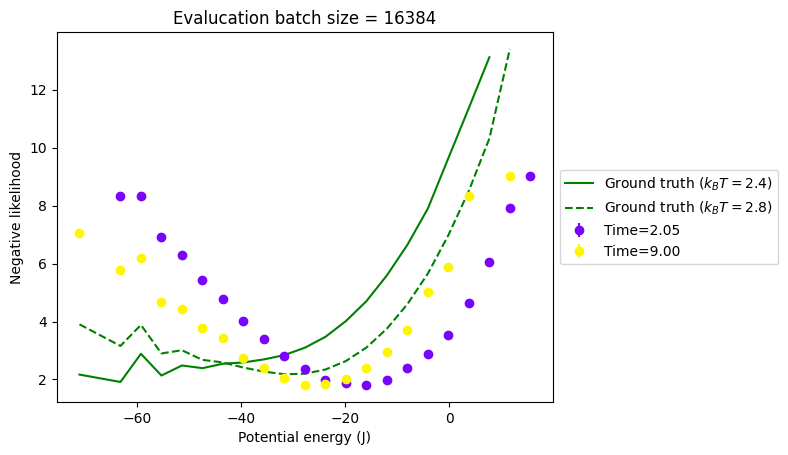

In [8]:
line_color = [plt.colormaps["gnuplot"](float(i)/float(len(diffusion_t))) for i in range(len(diffusion_t))]
# line_color = [plt.colormaps["gnuplot"](float(i)/3.) for i in range(3)]
# line_marker = ["o", "x", "o"]
# line_s = [1, 100, 10]
from scipy.ndimage import gaussian_filter1d

for idx_t in [18, len(diffusion_t)-1]:
    hist_E, bin_centers_E, P_E, F_E, idxF_E = histvar(seq_t[idx_t], ising_boltzman_prob_nn, bins, num_samples=1)
    sigma_gkernel = 3
    y_smoothed = gaussian_filter1d(F_E[0], sigma_gkernel)
    errors_smoothed = gaussian_filter1d(F_E[1], sigma_gkernel)

    # plt.plot(bin_centers_E[idxF_E], F_E[0], label="Time=%.2f"%(diffusion_t[idx_t]), c=line_color[idx_t], s=3)
    plt.errorbar(bin_centers_E[idxF_E], F_E[0], yerr=F_E[1], label="Time=%.2f"%(diffusion_t[idx_t]), c=line_color[idx_t], fmt="o")
    # plt.errorbar(bin_centers_E[idxF_E], y_smoothed, yerr=errors_smoothed, label="Time=%.2f"%(diffusion_t[i]), c=line_color[idx_t], fmt="-")
    # plt.fill_between(bin_centers_E[idxF_E], F_E[0]-F_E[1], y2=F_E[0]+F_E[1], label="Time=%.2f"%(diffusion_t[i]), color=line_color[idx_t], alpha=0.8, edgecolor=line_color[idx_t])

T = 2.4
if T in Reference_dict:
    plt.plot(Reference_dict[T][0], Reference_dict[T][1], c="green", label="Ground truth ($k_BT=%.1f$)"%T)
T = 2.8
if T in Reference_dict:
    plt.plot(Reference_dict[T][0], Reference_dict[T][1], c="green", label="Ground truth ($k_BT=%.1f$)"%T, linestyle="--")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Potential energy (J)")
plt.ylabel("Negative likelihood")
plt.title("Evalucation batch size = %d"%seq_t[0].shape[0])
# plt.xlim((magn.min(), magn.max()))

0.15279664651677058


Text(0.5, 1.0, 'Evalucation batch size = 16384')

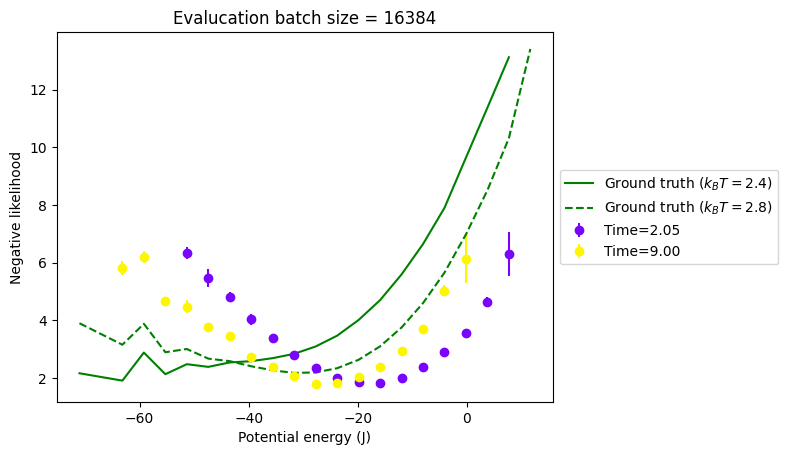

In [9]:
line_color = [plt.colormaps["gnuplot"](float(i)/float(len(diffusion_t))) for i in range(len(diffusion_t))]
# line_color = [plt.colormaps["gnuplot"](float(i)/3.) for i in range(3)]
# line_marker = ["o", "x", "o"]
# line_s = [1, 100, 10]
from scipy.ndimage import gaussian_filter1d

for idx_t in [18, len(diffusion_t)-1]:
    hist_E, bin_centers_E, P_E, F_E, idxF_E = histvar(seq_t[idx_t], ising_boltzman_prob_nn, bins, num_samples=4)
    sigma_gkernel = 3
    y_smoothed = gaussian_filter1d(F_E[0], sigma_gkernel)
    errors_smoothed = gaussian_filter1d(F_E[1], sigma_gkernel)

    # plt.plot(bin_centers_E[idxF_E], F_E[0], label="Time=%.2f"%(diffusion_t[idx_t]), c=line_color[idx_t], s=3)
    plt.errorbar(bin_centers_E[idxF_E], F_E[0], yerr=F_E[1], label="Time=%.2f"%(diffusion_t[idx_t]), c=line_color[idx_t], fmt="o")
    # plt.errorbar(bin_centers_E[idxF_E], y_smoothed, yerr=errors_smoothed, label="Time=%.2f"%(diffusion_t[i]), c=line_color[idx_t], fmt="-")
    # plt.fill_between(bin_centers_E[idxF_E], F_E[0]-F_E[1], y2=F_E[0]+F_E[1], label="Time=%.2f"%(diffusion_t[i]), color=line_color[idx_t], alpha=0.8, edgecolor=line_color[idx_t])
print(F_E[1].mean())

T = 2.4
if T in Reference_dict:
    plt.plot(Reference_dict[T][0], Reference_dict[T][1], c="green", label="Ground truth ($k_BT=%.1f$)"%T)
T = 2.8
if T in Reference_dict:
    plt.plot(Reference_dict[T][0], Reference_dict[T][1], c="green", label="Ground truth ($k_BT=%.1f$)"%T, linestyle="--")
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Potential energy (J)")
plt.ylabel("Negative likelihood")
plt.title("Evalucation batch size = %d"%seq_t[0].shape[0])
# plt.xlim((magn.min(), magn.max()))

In [10]:
# _logits_t, _ = loadmodelprediction("../epoch159_IntStep80_AMax10_clsT2.4L6shuffle0.6_scoreG1.0_bs9216")
# logits_t = [np.concatenate([logits_t[i], _logits_t[i]], axis=0) for i in range(len(_logits_t))]
# print([logits.shape for logits in logits_t])
# seq_t = logits2seq(logits_t)

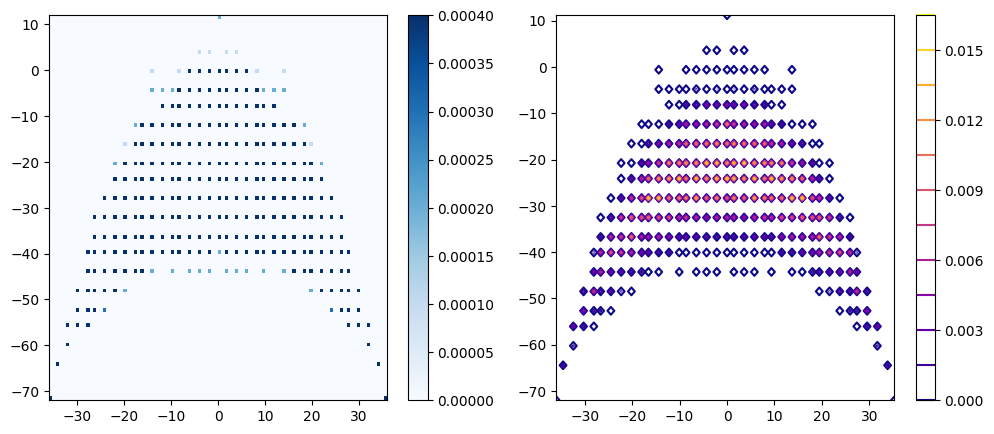

In [17]:
plt.figure(figsize=(12,5))
plt.subplot(121)
magn = Ising_magnetization(seq_t[-1])
pote = ising_boltzman_prob_nn(seq_t[-1])

H, xedges, yedges, img = plt.hist2d(magn, pote, bins=100, cmap="Blues", density=True, vmax=0.0004)
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
plt.colorbar()
# plt.scatter(magn_c4[ridx], pote_c4[ridx], marker="*", c="red", s=60)
# plt.ylim((-300, -25))
plt.subplot(122)
# _ = plt.imshow(seq_c4[ridx], cmap='Greys', vmin=0, vmax=1)
# plt.xticks([])
# plt.yticks([])
plt.contour(X, Y, H.T, levels=10, cmap="plasma")
plt.colorbar()
# plt.ylim((-300, -25))

In [12]:
from scipy.ndimage import gaussian_filter1d

ofile_fes = open("FES-E.dat", "wb")
# ofile_fes_smooth = open("FES-E-smoothed.dat", "wb")
ofile_prob = open("PROB-E.dat", "wb")
for idx_t, i in enumerate(range(len(diffusion_t))):

    hist_E, bin_centers_E, P_E, F_E, idxF_E = histvar(seq_t[i], ising_boltzman_prob_nn, bins, num_samples=4)
    np.savetxt(ofile_fes, bin_centers_E[idxF_E].reshape(1,-1), delimiter=" ", header=f"alpha-1={diffusion_t[i]}; Potential energy (J)")
    np.savetxt(ofile_fes, F_E[0].reshape(1,-1), delimiter=" ", header=f"alpha-1={diffusion_t[i]}; FES")
    np.savetxt(ofile_fes, F_E[1].reshape(1,-1), delimiter=" ", header=f"alpha-1={diffusion_t[i]}; ERROR of FES")

    # sigma_gkernel = 3
    # y_smoothed = gaussian_filter1d(F_E[0], sigma_gkernel)
    # errors_smoothed = gaussian_filter1d(F_E[1], sigma_gkernel)
    # np.savetxt(ofile_fes_smooth, bin_centers_E[idxF_E].reshape(1,-1), delimiter=" ", header=f"alpha-1={diffusion_t[i]}; Potential energy (J)")
    # np.savetxt(ofile_fes_smooth, y_smoothed.reshape(1,-1), delimiter=" ", header=f"alpha-1={diffusion_t[i]}; FES")
    # np.savetxt(ofile_fes_smooth, errors_smoothed.reshape(1,-1), delimiter=" ", header=f"alpha-1={diffusion_t[i]}; ERROR of FES")

    np.savetxt(ofile_prob, bin_centers_E.reshape(1,-1), delimiter=" ", header=f"alpha-1={diffusion_t[i]}; Potential energy (J)")
    np.savetxt(ofile_prob, P_E[0].reshape(1,-1), delimiter=" ", header=f"alpha-1={diffusion_t[i]}; PROB")
    np.savetxt(ofile_prob, P_E[1].reshape(1,-1), delimiter=" ", header=f"alpha-1={diffusion_t[i]}; ERROR of PROB")


ofile_fes.close()
ofile_prob.close()

In [13]:
import torch
import torch.nn as nn
class IsingGNN(nn.Module):
    def __init__(self, L):
        super(IsingGNN, self).__init__()
        self.L = L  # Lattice size
        self.edge_index = self.generate_lattice_edges(L)
    
    def generate_lattice_edges(self, L):
        edges = []
        for i in range(L):
            for j in range(L):
                # current node index
                node = i * L + j
                
                # Add edges to the right and down (to avoid double counting)
                right = i * L + (j + 1) % L
                down = ((i + 1) % L) * L + j
                left = i * L + (j - 1) % L
                
                edges.append([node, right])
                edges.append([node, down])
                edges.append([node, left])
                edges.append([node, up])
        
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        return edge_index

    def forward_hard(self, x):
        B, seq_len, K = x.shape
        assert seq_len == self.L**2
        edge_index = self.edge_index.to(x.device)
        # Get the spin values for the edge pairs
        spin_values = torch.argmax(x, dim=-1) * 2 - 1  # Convert one-hot encoding to -1, 1
        total_energy = torch.zeros(B).to(x.device)
        for edge in range(edge_index.size(1)):
            source = edge_index[0, edge]
            target = edge_index[1, edge]
            total_energy += -spin_values[:,source] * spin_values[:,target]/2.
        return total_energy

    def forward_soft(self, x):
        B, seq_len, K = x.shape
        assert seq_len == self.L**2
        edge_index = self.edge_index.to(x.device)
        # Get the spin values for the edge pairs
        spin_values = torch.argmax(x, dim=-1) * 2 - 1  # Convert one-hot encoding to -1, 1
        total_energy = torch.zeros(B).to(x.device)
        for i in range(seq_len):
            # Calculate energy assuming the current spin is -1
            spin_values_neg1 = spin_values.clone()
            spin_values_neg1[:,i] = -1
            energy_neg1 = torch.zeros(B).to(x.device)
            for edge in range(edge_index.size(1)):
                source = edge_index[0, edge]
                target = edge_index[1, edge]
                energy_neg1 += -spin_values_neg1[:,source] * spin_values_neg1[:,target]/2.

            # Calculate energy assuming the current spin is 1
            spin_values_pos1 = spin_values_neg1
            spin_values_pos1[:,i] = 1
            energy_pos1 = torch.zeros(B).to(x.device)
            for edge in range(edge_index.size(1)):
                source = edge_index[0, edge]
                target = edge_index[1, edge]
                energy_pos1 += -spin_values_pos1[:,source] * spin_values_pos1[:,target]/2.
            del spin_values_pos1
            # Combine the energies weighted by the probabilities
            spin_energy = x[:, i, 0] * energy_neg1 + x[:, i, 1] * energy_pos1
            total_energy += spin_energy
        return total_energy/seq_len
    
ising_model = IsingGNN(seq_dim[0])

ModuleNotFoundError: No module named 'torch'